In [17]:
#read data 
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from collections import Counter

train=pd.read_csv('/Users/jinjuanshi/Documents/Statistics/251/Project/data/train.csv')
test=pd.read_csv('/Users/jinjuanshi/Documents/Statistics/251/Project/data/test.csv')

x_train=train['TITLE']+train['ABSTRACT']
y_train=train[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']]
x_test=test['TITLE']+test['ABSTRACT']


print(train.shape)
print(test.shape)
print(x_train.shape,type(x_train),y_train.shape,type(y_train))
train

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinjuanshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(20972, 9)
(8989, 3)
(20972,) <class 'pandas.core.series.Series'> (20972, 6) <class 'pandas.core.frame.DataFrame'>


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


# Data Information


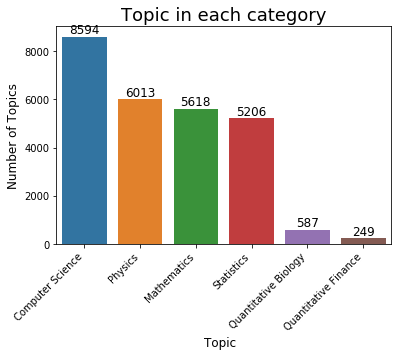

In [18]:
categories = list(train.columns.values[3:])
categories


ax= sns.barplot(categories, train.iloc[:,3:].sum().values)
plt.title("Topic in each category", fontsize=18)
plt.ylabel('Number of Topics', fontsize=12)
plt.xlabel('Topic  ', fontsize=12)
plt.xticks(rotation=45,ha='right')


#adding the text labels
rects = ax.patches
labels = train.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

There exists unblance issue, so we need to deal with it in order to get better prediction accuracy.

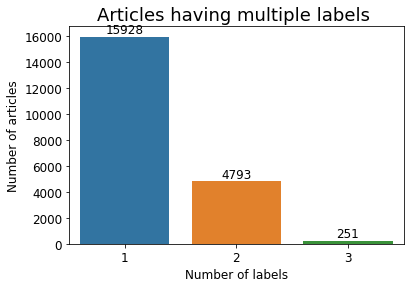

In [19]:
##Counting the number of article having multiple labels.
rowSums = train.iloc[:,3:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()


ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Articles having multiple labels ",fontsize=18)
plt.ylabel('Number of articles', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',fontsize=12)
plt.show()

(0, 6)

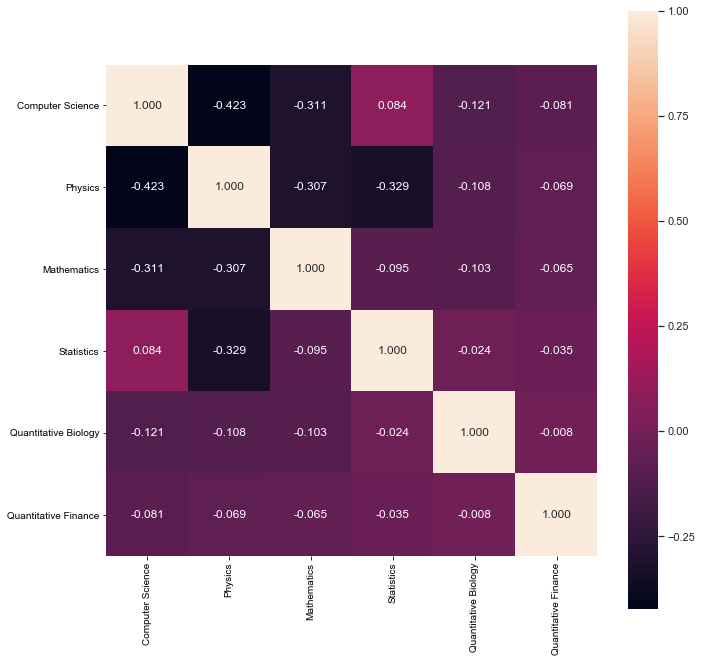

In [3]:
columnNames =list(train.columns.values[3:])
corr = train.iloc[:,3:].corr()

fig, ax = plt.subplots(figsize=(11,11))
sns.set(font_scale=1)
hm=sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.3f',
              yticklabels = columnNames, xticklabels = columnNames)
ax.set_ylim(6, 0 )
ax.set_xlim(0, 6 )

See if there is some correlation between different labels. Computer Science and Statistics are most related.

# Data Preprocess

In [58]:
#Have a peek the first comment, the text needs to be cleaned
x_train

0        Reconstructing Subject Specific Effect Maps Pr...
1        Rotation Invariance Neural Network Rotation in...
2        Spherical polyharmonics Poisson kernels polyha...
3        finite element approximation stochastic Maxwel...
4        Comparative study Discrete Wavelet Transforms ...
                               ...                        
20967    Contemporary machine learning guide practition...
20968    Uniform diamond coatings hard alloy cutting in...
20969    Analysing Soccer Games with Clustering Concept...
20970    Efficient Simulation Left Tail Correlated norm...
20971    optional stopping problem Bayesians Recently o...
Length: 20972, dtype: object

In [59]:
##deal with column name
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print('Train Data shape: ', train.shape)

Train Data shape:  (20972, 10)


In [60]:
#clean deta
import re

def remove_pattern(text, pattern): 
    r = re.findall(pattern, text) 
    for i in r:
        text = re.sub(i, "", text) 
    return text


for column in ['title', 'abstract']:
    train[column] = np.vectorize(remove_pattern)(train[column], "@[\w]*") 
    train[column] = np.vectorize(remove_pattern)(train[column], "#[\w]*") 
    train[column] = np.vectorize(remove_pattern)(train[column], '[0-9]') 
    train[column] = train[column].str.replace("[^a-zA-Z#]", " ") 
    train[column] = train[column].apply(lambda x: ' '.join([i for i in x.split() if len(i) > 3]))
    train['description'] = train['title'] + " " + train['abstract']
    
x_train= train['title'] + " " + train['abstract']
print(x_train[0])

Reconstructing Subject Specific Effect Maps Predictive models allow subject specific inference when analyzing disease related alterations neuroimaging data Given subject data inference made levels global identifiying condition presence subject local detecting condition effect each individual measurement extracted from subject data While global inference widely used local inference which used form subject specific effect maps rarely used because existing models often yield noisy detections composed dispersed isolated islands this article propose reconstruction method named improve subject specific detections predictive modeling approaches particular binary classifiers specifically aims reduce noise sampling error associated with using finite sample examples train classifiers proposed method wrapper type algorithm that used with different binary classifiers diagnostic manner without information condition presence Reconstruction posed Maximum Posteriori problem with prior model whose para

In [61]:
#transform to decimal see how many possible target
y_train_arr=y_train.to_numpy()#convert df to numpy

def convert_to_decimal(arr):
    x=0
    for i in range(len(arr)):
        x=x+2**(len(arr)-i-1)*arr[i]
    return x

dec=np.apply_along_axis(convert_to_decimal, axis=1, arr=y_train_arr)
print(Counter(dec))# count the number of each class, found 13 only have 
idx=np.argwhere(dec==13).ravel()
idx
#duplicate the sample only have 1 count in order to split data into 2/3 for train and 1/3 for test
x_train_add=np.concatenate((x_train, x_train[idx]), axis=0)
print(y_train.shape)
y_train_add=np.concatenate((y_train,y_train.iloc[idx]), axis=0)
print(y_train_add.shape)


Counter({16: 5120, 32: 4910, 8: 3610, 36: 2285, 4: 1636, 12: 825, 40: 682, 2: 443, 48: 437, 24: 293, 1: 209, 44: 179, 6: 105, 20: 99, 52: 36, 34: 30, 5: 24, 56: 19, 28: 9, 33: 9, 38: 5, 3: 4, 37: 2, 13: 1})
(20972, 6)
(20973, 6)


In [62]:
#split it into 2/3 training data and 1/3 testing data
xx_train, xx_test, xy_train, xy_test = train_test_split(
    x_train_add, y_train_add, test_size=0.33, random_state=42,stratify=y_train_add)

print(xx_train.shape,xy_train.shape)
print(xx_test.shape,xy_test.shape)

(14051,) (14051, 6)
(6922,) (6922, 6)


# Feature extraction

In [63]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words)
xx_train_vectors = vectorizer.fit_transform(xx_train)
xx_test_vectors = vectorizer.transform(xx_test)
print(xx_train_vectors.shape, xx_test_vectors.shape)
print(type(xx_train_vectors.shape))

print(xy_train.shape,xy_test.shape)
print(type(y_train))

(14051, 38360) (6922, 38360)
<class 'tuple'>
(14051, 6) (6922, 6)
<class 'pandas.core.frame.DataFrame'>


# Binary Relevance on KNN

In [75]:
## use loop for each label to predict
import time
start = time.time()

c=xy_train.shape[1]
y_pred=np.zeros((xy_test.shape[0],xy_test.shape[1]))
for i in range(c):
    knn=KNeighborsClassifier()
    knn.fit(xx_train_vectors,xy_train[:,i])
    predicted[:,i]=knn.predict(xx_test_vectors)

score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(score,f1)

print("Inference - Finished in {}s".format((time.time() - start)))


0.6006934412019648 0.7630857279122452
Inference - Finished in 39.14921712875366s


## Acurracy

In [64]:
#Calculate test accuracy by fractional values
def accuracy_fraction(y_test, predicted):
    test_size = y_test.shape[0]
    frac_values = []
    for i in range(0,test_size):
        single_frac = accuracy_score(y_test[i,], predicted[i,])
        frac_values.append(single_frac)
    test_scores = sum(frac_values)/test_size
    return test_scores  


#Calculate average score for 6 labels
def accuracy_average(y_test, predicted):  
    score=[]
    for i in range(6):
        score.append(accuracy_score(y_test[:,i],predicted[:,i]))
    test_score=np.mean(score)
    return test_score


## 1.OneVsRest
OneVsRest is actually a binary relevance method

## 1.1 KNN

In [ ]:
# use OneVsRest wrap KNN
from sklearn.neighbors import KNeighborsClassifier

import time
start = time.time()

test_score=[]
f1=[]
for i in range(1,13):
    knn=OneVsRestClassifier(KNeighborsClassifier(n_neighbors=i))
    knn.fit(xx_train_vectors, xy_train)
    predicted=knn.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)
                           
print("Inference - Finished in {}s".format((time.time() - start)))


In [9]:
# copy result into a variable for plot
test_score_knn=[0.5473851488009246, 0.4968217278243282, 0.5784455359722623, 0.5524414908985842, 0.6006934412019648, 0.5839352788211499, 0.6069055186362323, 0.5894250216700375, 0.6122507945680439, 0.5973707021092169, 0.611239526148512, 0.5993932389482809]
f1_knn=[0.7087138836234131, 0.6676348547717843, 0.7450516986706056, 0.7202042018456706, 0.7630857279122452, 0.7465113301753937, 0.7694065299741447, 0.7537720299226575, 0.7736168156559555, 0.7614251542238448, 0.7724104491181284, 0.7627947817360762]
time=376.03729796409607
max_knn=max(test_score_knn)
print(np.argmax(test_score_knn))

8


In [16]:
import time
start = time.time()

knn=OneVsRestClassifier(KNeighborsClassifier(n_neighbors=9))
knn.fit(xx_train_vectors, xy_train)
predicted=knn.predict(xx_test_vectors)
print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

Test Accuracy: 0.6123
Fractional Accuracy: 0.9098
Average Accuracy: 0.9098
Inference - Finished in 45.153093099594116s


In this project, we use 2 accuracy: exact accuracy(6 labels are predicted correct), average accuracy(only if 1 label is predicted correct)


## 1.2 NLC


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

import time
start = time.time()

def nearest_local_centroid(k,x_test,y_test,x_train,y_train): # k is number of neigbors
    c=len(set(y_test))
    mat=np.zeros((k,x_test.shape[0],c))# initialize a 3d matrix
    for i in range(1,k+1):
        for j in range(c):
            x_sample=x_train[np.argwhere(y_train==j).ravel(),:]#get ith class sample
            #print(x_sample.shape,x_sample.dtype)
            neighbor=NearestNeighbors(n_neighbors=i)
            neighbor.fit(x_sample)
            t=neighbor.kneighbors(x_test,return_distance=False)# get test point k neareat index
            #print(t.shape)
            x_sample = x_sample.toarray()
            centroid=np.mean(x_sample[t,:],axis=1)#extrat k nearest train point, compute centroid
            dist=np.sqrt(np.sum(np.square(x_test-centroid),axis=1))#compute euclidean distance between test point and its centroid
            mat[i-1,:,j]=np.squeeze(dist)# store the distance into 3darrary
    res=np.apply_along_axis(np.argmin, -1, mat)
    return res


##apply nlc function for every colum y
level=xy_train.shape[1]
test_score=[]
f1=[]
for i in range(1,13):
    predicted=np.zeros((xy_test.shape[0],xy_test.shape[1]))    
    for j in range(level):
        res=nearest_local_centroid(i,xx_test_vectors,xy_test[:,j],xx_train_vectors,xy_train[:,j])
        predicted[:,j]=res[i-1,:]
        
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))

print(test_score)
print(f1)


print("Inference - Finished in {}s".format((time.time() - start)))

In [62]:
test_score_nlc=[0.5473851488009246, 0.5265819127419821, 0.5398728691129732, 0.5567754984108639, 0.5644322450158914, 0.570644322450159, 0.5794568043917943, 0.5839352788211499, 0.5862467494943658, 0.5949147645189252, 0.5954926321872291, 0.5982375036116729]
f1_nlc=[0.7087138836234131, 0.6949766960124288, 0.7079285672735735, 0.720927495291902, 0.7290207715133532, 0.7345454545454544, 0.7436511739338763, 0.747693977211069, 0.7509230676109194, 0.7565328622769081, 0.7591383413681578, 0.7613691931540343]
time=29174.030782222748
max_nlc=max(test_score_nlc)

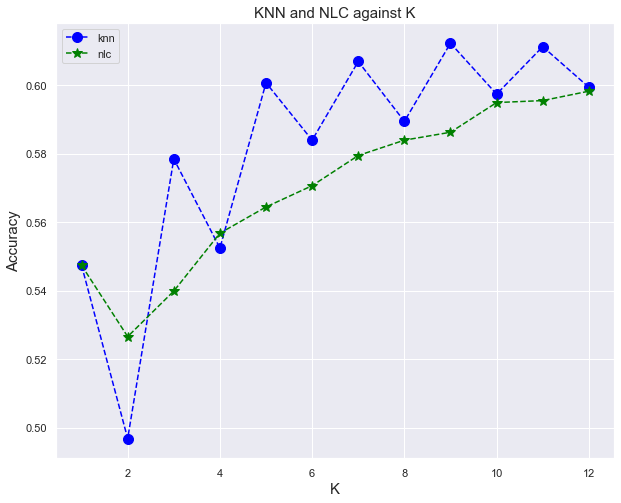

In [61]:
#plot against K nearest neighbor

plt.figure(figsize=(10, 8))

plt.plot(range(1,13),test_score_knn, color='blue', linestyle='dashed', 
         marker='o',label='knn', markersize=10)
plt.plot(range(1,13),test_score_nlc, color='green', linestyle='dashed', 
         marker='*',label='nlc', markersize=10)

plt.title('KNN and NLC against K',fontsize=15)
plt.xlabel('K',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.savefig('knn_nlc.pdf')
plt.show();

## 1.3 Multinomial Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
import time
start = time.time()

mnb=OneVsRestClassifier(MultinomialNB())
mnb.fit(xx_train_vectors, xy_train)
predicted=mnb.predict(xx_test_vectors)
print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

Test Accuracy: 0.5680
Fractional Accuracy: 0.9025
Average Accuracy: 0.9025
Inference - Finished in 1.4304170608520508s


## 1.4 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

import time
start = time.time()

test_score=[]
f1=[]
for i in range(-6,6):
    lr=OneVsRestClassifier(LogisticRegression(C=2**i,penalty='l2',random_state=0))
    lr.fit(xx_train_vectors, xy_train)
    predicted=lr.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)
                           
print("Inference - Finished in {}s".format((time.time() - start)))


In [19]:
test_score=[0.04955215255706443, 0.17206009823750362, 0.38298179716844843, 0.5286044495810459, 0.6001155735336607, 0.6300202253683906, 0.6472117885004334, 0.6551574689396128, 0.6589136087835885, 0.6541462005200809, 0.6495232591736493, 0.6422999133198497]
f1=[0.13488618316569612, 0.33942655655562776, 0.5766018887067822, 0.707235930135847, 0.7652027027027027, 0.7891987159312646, 0.803495599729214, 0.8090461426226518, 0.8113355441664154, 0.8087019057892844, 0.8052211228990345, 0.8010695187165775]
time=42.086735010147095
max_lr=max(test_score)
np.argmax(test_score)

8

In [20]:
from sklearn.linear_model import LogisticRegression
import time
start = time.time()

lr=OneVsRestClassifier(LogisticRegression(C=2,penalty='l2',random_state=0))
lr.fit(xx_train_vectors, xy_train)
predicted=lr.predict(xx_test_vectors)
print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test Accuracy: 0.6554
Fractional Accuracy: 0.9244
Average Accuracy: 0.9244
Inference - Finished in 2.6101980209350586s


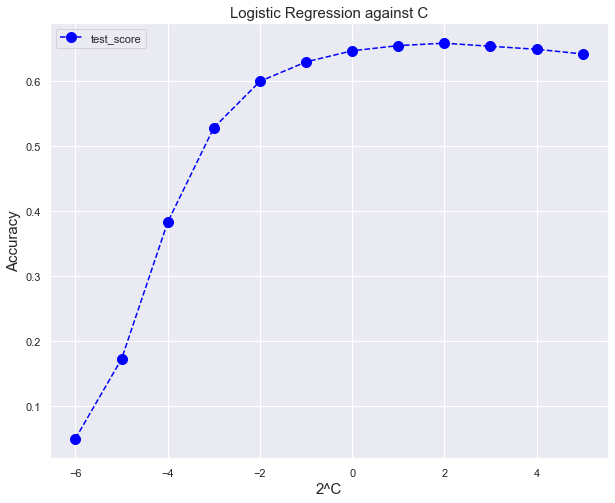

In [63]:
#plot against C nearest neighbor

plt.figure(figsize=(10, 8))

plt.plot(range(-6,6),test_score, color='blue', linestyle='dashed', 
         marker='o',label='test_score', markersize=10)


plt.title('Logistic Regression against C',fontsize=15)
plt.xlabel('2^C',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.savefig('lr.pdf')
plt.show();

## 1.5 Support Vector Machine

In [ ]:
##apply linear kernel svm

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import time
start = time.time()

test_score=[]
f1=[]
for i in range(-6,6):
    svc_linear=OneVsRestClassifier(LinearSVC(random_state=0, C=2**i,penalty='l2'))
    svc_linear.fit(xx_train_vectors, xy_train)
    predicted=svc_linear.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)
      


print("Inference - Finished in {}s".format((time.time() - start)))

In [21]:
test_score_linear=[0.5540306269864201, 0.6157180005778676, 0.6431667148223057, 0.6554464027737648, 0.6620918809592603, 0.6587691418665126, 0.6508234614273332, 0.6357989020514302, 0.6199075411730713, 0.6071944524703843, 0.5978041028604449, 0.5933256284310893]
f1_linear=[0.7288606052399973, 0.7781762295081966, 0.7994028736704608, 0.809384164222874, 0.8141347025067955, 0.8115942028985507, 0.8072610784837159, 0.7999292619665173, 0.7906213364595545, 0.7831381733021078, 0.7782255709362771, 0.7750816612225851]
time_linear=16.751522064208984
max_svm_linear=max(test_score_linear)
np.argmax(test_score_linear)

4

In [22]:
##Calculate 3 accuracy

from sklearn.svm import LinearSVC
import time
start = time.time()

svc_linear=OneVsRestClassifier(LinearSVC(random_state=0, C=2**-2,penalty='l2'))
svc_linear.fit(xx_train_vectors, xy_train)
predicted=svc_linear.predict(xx_test_vectors)
print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

Test Accuracy: 0.6621
Fractional Accuracy: 0.9259
Average Accuracy: 0.9259
Inference - Finished in 1.8194141387939453s


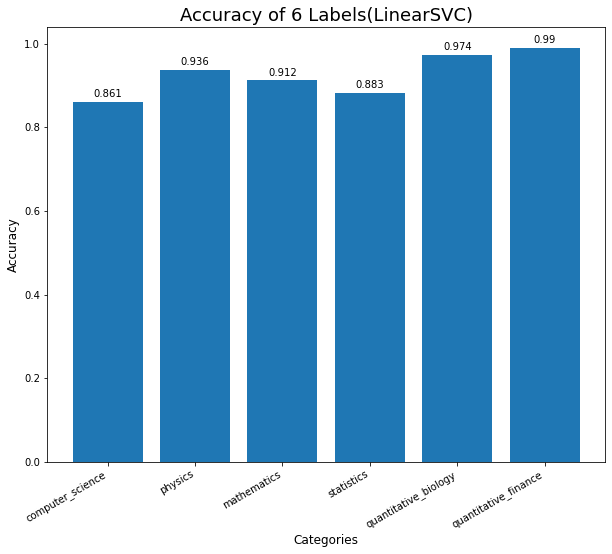

In [56]:
##plot highest accuracy for 6 labels
from sklearn.svm import LinearSVC
svc_linear=OneVsRestClassifier(LinearSVC(random_state=0, C=0.25,penalty='l2'))
svc_linear.fit(xx_train_vectors, xy_train)
predicted=svc_linear.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
score=[]
for i in range(6):
    score.append(accuracy_score(xy_test[:,i],predicted[:,i]))

categories = ['computer_science','physics','mathematics', 'statistics', 
              'quantitative_biology', 'quantitative_finance']
#list(train.columns.values[3:])
labels= np.around(np.array(score),3)

fig, ax = plt.subplots(figsize=(10, 8))
rects= ax.bar(categories,labels)
plt.title("Accuracy of 6 Labels(LinearSVC)", fontsize=18)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Categories', fontsize=12)
ax.set_xticklabels(categories , rotation=30, ha='right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.savefig('accuracy_6labels_1.pdf')
plt.show()

In [ ]:
##apply poly kernel sv

from sklearn.svm import SVC

import time
start = time.time()

test_score=[]
f1=[]
for i in range(-6,6):
    poly=OneVsRestClassifier(SVC(C=2**i,kernel='poly',gamma='scale',random_state=0))
    poly.fit(xx_train_vectors, xy_train)
    predicted=poly.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)
      

print("Inference - Finished in {}s".format((time.time() - start)))

In [66]:
test_score_poly=[0.0, 0.0, 0.0, 0.0, 0.0001444669170759896, 0.012424154868535105, 0.18246171626697485, 0.25166136954637386, 0.25166136954637386, 0.25166136954637386, 0.25166136954637386, 0.25166136954637386]
f1_poly=[0.0, 0.0, 0.0, 0.0, 0.00023060071486221607, 0.029281579843377595, 0.35466617484323126, 0.4441944973178751, 0.44405987713074324, 0.44405987713074324, 0.444098303911388, 0.444098303911388]
time=31184.231511831284
max_svm_poly=max(test_score_poly)

In [ ]:
##apply gaussian kernel svm

from sklearn.svm import SVC

import time
start = time.time()

test_score=[]
f1=[]
for i in range(-6,6):
    gk=OneVsRestClassifier(SVC(C=2**i,kernel='rbf',gamma='scale',random_state=0))
    gk.fit(xx_train_vectors, xy_train)
    predicted=gk.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)
      

print("Inference - Finished in {}s".format((time.time() - start)))

In [23]:
test_score_gk=[0.0, 0.004189540595203698, 0.14923432533949726, 0.46056053163825483, 0.6006934412019648, 0.6450447847442936, 0.6619474140421844, 0.6661369546373881, 0.6654146200520081, 0.6651256862178561, 0.6652701531349321, 0.6652701531349321]
f1_gk=[0.0, 0.014187643020594968, 0.29755070799846917, 0.647435425711973, 0.7664709719504239, 0.8001745744747178, 0.8153229723166585, 0.8176456427539721, 0.8160067498342675, 0.8157926461723931, 0.8159353905496626, 0.8159353905496626]
time=11396.25817322731
max_svm_gk=max(test_score_gk)
np.argmax(test_score_gk)

7

In [25]:
##Calculate 3 accuracy
from sklearn.svm import SVC
import time
start = time.time()

gk=OneVsRestClassifier(SVC(C=2**1,kernel='rbf',gamma='scale',random_state=0))
gk.fit(xx_train_vectors, xy_train)
predicted=gk.predict(xx_test_vectors)
print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

Test Accuracy: 0.6661
Fractional Accuracy: 0.9270
Average Accuracy: 0.9270
Inference - Finished in 1433.6416549682617s


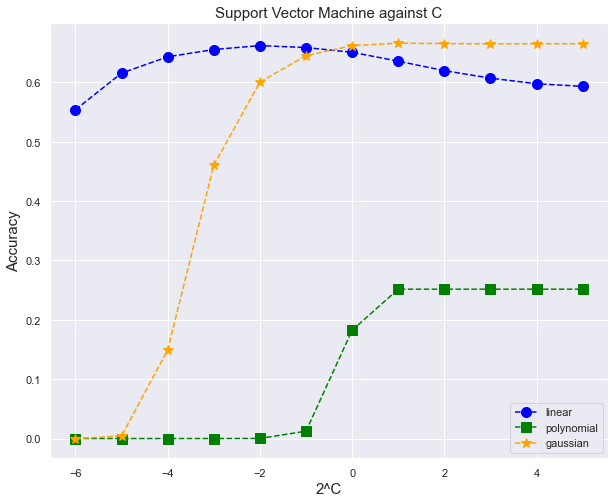

In [64]:
# plot svm of linear,polynomial and gaussian kernel againt C
plt.figure(figsize=(10, 8))

plt.plot(range(-6,6),test_score_linear, color='blue', linestyle='dashed', 
         marker='o',label='linear', markersize=10)
plt.plot(range(-6,6),test_score_poly, color='green', linestyle='dashed', 
         marker='s',label='polynomial', markersize=10)
plt.plot(range(-6,6),test_score_gk, color='orange', linestyle='dashed', 
         marker='*',label='gaussian', markersize=10)

plt.title('Support Vector Machine against C',fontsize=15)
plt.xlabel('2^C',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.savefig('svm.pdf')
plt.show();

## 1.6 Ensemble Learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#apply random forest
import time
start = time.time()

#calculate out of bag error from 10-500
min_estimators = 20
max_estimators = 500
test_score=[]
oob_score=[]
f1=[]
for i in range(min_estimators,max_estimators+1,20):
    rf=OneVsRestClassifier(RandomForestClassifier(n_estimators=i,min_samples_leaf=1,max_features='sqrt',
                                   bootstrap=True,warm_start=True,random_state=0))
    rf.fit(xx_train_vectors, xy_train)
    predicted=rf.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
#    oob_score.append(rf.oob_score_)
print(test_score)
print(f1)


print("Inference - Finished in {}s".format((time.time() - start)))



In [26]:
test_score_rf=[0.5731002600404508, 0.5996821727824329, 0.6099393238948281, 0.6180294712510835, 0.6223634787633632, 0.6214966772609073, 0.6226524125975151, 0.6220745449292112, 0.6209188095926033, 0.6227968795145912, 0.6227968795145912, 0.6235192140999711, 0.624819416353655, 0.624963883270731, 0.6235192140999711, 0.625541750939035, 0.625108350187807, 0.6261196186073389, 0.624819416353655, 0.6266974862756429, 0.6253972840219589, 0.625108350187807, 0.6264085524414909, 0.6262640855244149, 0.6271308870268708]
f1_rf=[0.7431139646869984, 0.7623085685356283, 0.7702872983870968, 0.7768356259028956, 0.7793674698795182, 0.7774361548597603, 0.779191476026324, 0.7791084080506615, 0.778042659974906, 0.779178425838821, 0.7802128991859737, 0.7801365144968377, 0.7812030075187969, 0.7811991488296407, 0.781068052338321, 0.7818909454727364, 0.7821410705352675, 0.782064911512726, 0.7809547644372145, 0.7820600911987007, 0.7818159110778068, 0.7814081339414006, 0.7819783790539275, 0.7819079152870619, 0.7820328606234772]
time=3934.539942741394
max_rf=max(test_score_rf)
np.argmax(test_score_rf)

24

In [28]:
##Calculate 3 accuracy
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()

rf=OneVsRestClassifier(RandomForestClassifier(n_estimators=500,min_samples_leaf=1,max_features='sqrt',
                                   bootstrap=True,warm_start=True,random_state=0))
rf.fit(xx_train_vectors, xy_train)
predicted=rf.predict(xx_test_vectors)

print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

Test Accuracy: 0.6271
Fractional Accuracy: 0.9160
Average Accuracy: 0.9160
Inference - Finished in 389.4060649871826s


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#apply adaboost classifier
import time
start = time.time()

#calculate out of bag error from 10-500
min_estimators = 20
max_estimators = 500
test_score=[]
oob_score=[]
f1=[]
for i in range(min_estimators,max_estimators+1,20):
    adaboost=OneVsRestClassifier(AdaBoostClassifier(n_estimators=i,random_state=0))
    adaboost.fit(xx_train_vectors, xy_train)
    predicted=adaboost.predict(xx_test_vectors)
    test_score.append(accuracy_score(xy_test,predicted))
    f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)

print("Inference - Finished in {}s".format((time.time() - start)))


In [10]:
test_score_ada=[0.45131464894539153, 0.5059231436001156, 0.5310603871713377, 0.5447847442935567, 0.5521525570644322, 0.5576422999133198, 0.5673215833574111, 0.5729557931233747, 0.5748338630453627, 0.5738225946258307, 0.5749783299624386, 0.5774342675527304, 0.5793123374747183, 0.5777232013868824, 0.5800346720600983, 0.5794568043917943, 0.5817682750650102, 0.5814793412308581, 0.5820572088991621, 0.582635076567466, 0.584079745738226, 0.5879803524992777, 0.5913030915920254, 0.5907252239237215, 0.5915920254261774]
f1_ada=[0.6664090177133655, 0.7080054951917073, 0.7255364008433584, 0.7378462667400477, 0.7435678575783442, 0.7487403630182723, 0.7557648195098393, 0.760310674935276, 0.7621504860194407, 0.7620646244229962, 0.7624070966195158, 0.7639803616333374, 0.7673376739740756, 0.7662291169451074, 0.7671477991172612, 0.7680590265381412, 0.7697794685846757, 0.7702646446625037, 0.7706607877018411, 0.7708817742800931, 0.7706323687031084, 0.7736983040761678, 0.7745238095238096, 0.7738902772819232, 0.7744316152838948]
time=5182.476768016815
max_ada=max(test_score_ada)

In [68]:
##apply 500 trees for bagging
import time
start = time.time()

from sklearn.ensemble import BaggingClassifier
bagging=OneVsRestClassifier(BaggingClassifier(n_estimators=500, bootstrap= True, oob_score= True, random_state=0))
bagging.fit(xx_train_vectors, xy_train)
predicted=bagging.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')

print("Inference - Finished in {}s".format((time.time() - start)))

Inference - Finished in 20568.447371959686s


In [74]:
test_score_500=0.58003
f1_500=0.7760741561242932
time_500=20568.447371959686

0.58

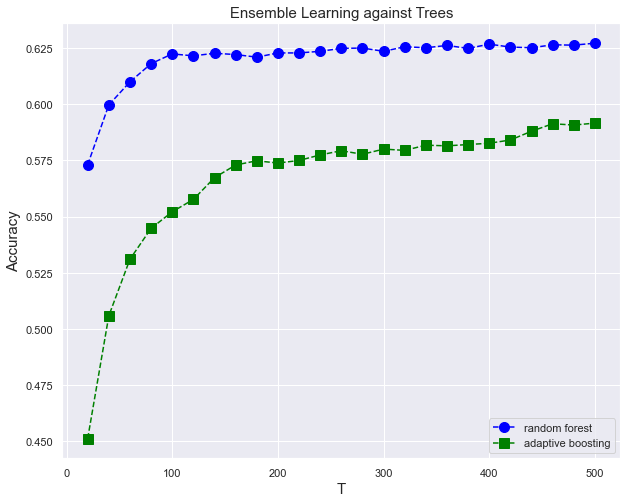

In [65]:
# plot random forest,adaboost agains T
plt.figure(figsize=(10, 8))
min_estimators = 20
max_estimators = 500
plt.plot(range(min_estimators,max_estimators+1,20),test_score_rf, color='blue', linestyle='dashed', 
         marker='o',label='random forest', markersize=10)
plt.plot(range(min_estimators,max_estimators+1,20),test_score_ada, color='green', linestyle='dashed', 
         marker='s',label='adaptive boosting', markersize=10)


plt.title('Ensemble Learning against Trees',fontsize=15)
plt.xlabel('T',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.savefig('enln.pdf')
plt.show();

## 1.7 Comparison of Accuracy

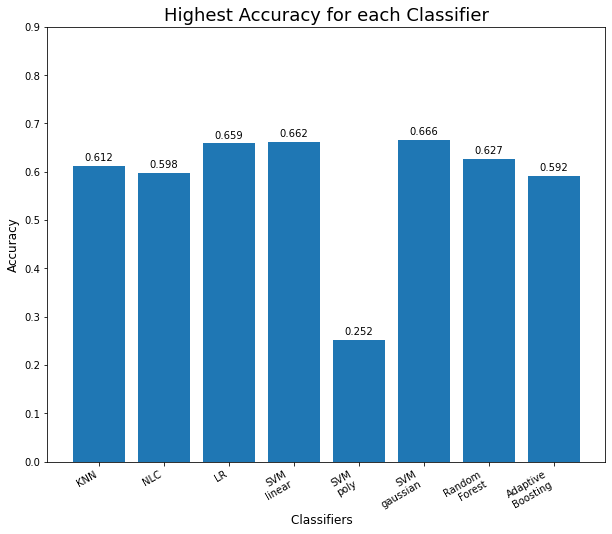

In [76]:
##bar plot for all highest accuracy
classifer_name=['KNN','NLC','LR','SVM\nlinear','SVM\npoly','SVM\ngaussian','Random\nForest','Adaptive\nBoosting']
max_value=[max_knn,max_nlc,max_lr,max_svm_linear,max_svm_poly,max_svm_gk,max_rf,max_ada]
labels = np.around(np.array(max_value),3)

fig, ax = plt.subplots(figsize=(10, 8))
rects= ax.bar(classifer_name, labels)
plt.title("Highest Accuracy for each Classifier", fontsize=18)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Classifiers  ', fontsize=12)
plt.xticks(rotation=30,ha='right')
plt.ylim(0,0.9)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.savefig('summary_ovr.pdf')
plt.show()



# 2 LabelPowerSet
Some parameters are choosen based on the best result from first part.

## 2.1 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.problem_transform import LabelPowerset

import time
start = time.time()


knn=LabelPowerset(KNeighborsClassifier(n_neighbors=12))
knn.fit(xx_train_vectors, xy_train)
predicted=knn.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(test_score)
print(f1)
                           
print("Inference - Finished in {}s".format((time.time() - start)))

In [ ]:
test_score_knn_2=0.6336318982952904
f1_knn_2=0.7653925925925925
time_knn_2=4865.00817489624

## 2.2 Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset

import time
start = time.time()

lr=LabelPowerset(LogisticRegression(C=4,penalty='l2',random_state=0))
lr.fit(xx_train_vectors, xy_train)
predicted=lr.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(test_score)
print(f1)
                           
print("Inference - Finished in {}s".format((time.time() - start)))

In [ ]:
0.6830395839352789
0.8108108108108107
Inference - Finished in 501.2474458217621s

## 2.3 SVM_Linear & gaussian

In [ ]:
##apply linear kernel svm
from skmultilearn.problem_transform import LabelPowerset
from sklearn.svm import LinearSVC

import time
start = time.time()

svc_linear=LabelPowerset(LinearSVC(random_state=0, C=0.25,penalty='l2'))
svc_linear.fit(xx_train_vectors, xy_train)
predicted=svc_linear.predict(xx_test_vectors)
test_score.append(accuracy_score(xy_test,predicted))
f1.append(f1_score(xy_test,predicted,average='micro'))
print(test_score)
print(f1)
 
print("Inference - Finished in {}s".format((time.time() - start)))

0.6892516613695464
[0.861 0.934 0.909 0.878 0.974 0.992]


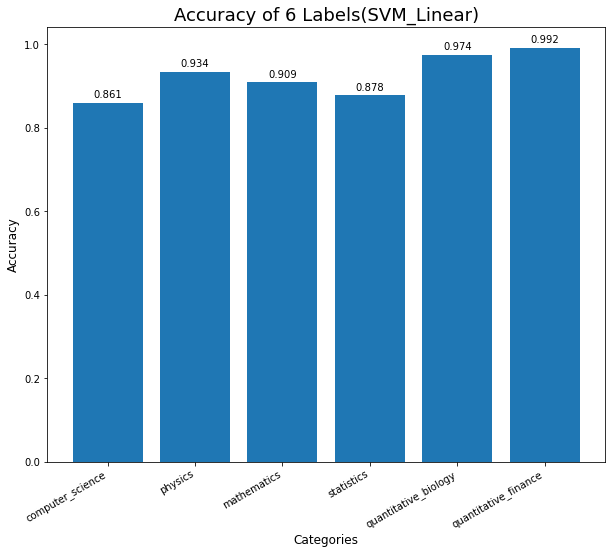

In [58]:
##plot highest accuracy for 6 labels
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import LabelPowerset

svc_linear=LabelPowerset(LinearSVC(random_state=0, C=0.25,penalty='l2'))
svc_linear.fit(xx_train_vectors, xy_train)
predicted=svc_linear.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
print(test_score)

predicted=predicted.toarray()#transform from sparse to array

score=[]
for i in range(6):
    score.append(accuracy_score(xy_test[:,i],predicted[:,i]))

categories = ['computer_science','physics','mathematics', 'statistics', 'quantitative_biology', 'quantitative_finance']

labels= np.around(np.array(score),3)
print(labels)
fig, ax = plt.subplots(figsize=(10, 8))
rects= ax.bar(categories,labels)
plt.title("Accuracy of 6 Labels(SVM_Linear)", fontsize=18)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Categories', fontsize=12)
ax.set_xticklabels(categories , rotation=30, ha='right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.savefig('accuracy_6labels_2.pdf')
plt.show()

In [ ]:
##apply gaussian kernel svm
from skmultilearn.problem_transform import LabelPowerset
from sklearn.svm import SVC

import time
start = time.time()

svm_gk=LabelPowerset(SVC(C=4,kernel='rbf',gamma='scale',random_state=0))
svm_gk.fit(xx_train_vectors, xy_train)
predicted=svm_gk.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(test_score)
print(f1)
 
print("Inference - Finished in {}s".format((time.time() - start)))

In [ ]:
test_score=0.6905518636232303
time_gk=42373.64761304855

In [ ]:
##Calculate 3 accuracy
from skmultilearn.problem_transform import LabelPowerset
from sklearn.svm import SVC

import time
start = time.time()

svm_gk=LabelPowerset(SVC(C=4,kernel='rbf',gamma='scale',random_state=0))
svm_gk.fit(xx_train_vectors, xy_train)
predicted=svm_gk.predict(xx_test_vectors)

print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

## 2.4 Random Foest

In [75]:
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset

import time
start = time.time()


rf= LabelPowerset(RandomForestClassifier(n_estimators=200,min_samples_leaf=1,max_features='sqrt',
                               bootstrap=True,warm_start=True,random_state=0))
rf.fit(xx_train_vectors, xy_train)
predicted=rf.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')

print(test_score)
print(f1)
print("Inference - Finished in {}s".format((time.time() - start)))

0.6336318982952904
0.7510689719278678
Inference - Finished in 803.5288920402527s


# 3.Classifier Chain

## 3.1 KNN(dead)

## 3.2 Logistic Regression

In [ ]:
# using classifier chains and logistic regression
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

import time
start = time.time()


# initialize classifier chains multi-label classifier
lr=ClassifierChain(LogisticRegression(C=4,penalty='l2',random_state=0))
# Training logistic regression model on train data
lr.fit(xx_train_vectors, xy_train)
# predict
predicted=lr.predict(xx_test_vectors)
# accuracy
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(test_score)
print(f1)
                           
print("Inference - Finished in {}s".format((time.time() - start)))


In [ ]:
test_score=0.6792834440913031
f1=0.8094758661533905
test_time=517.7802133560181s

## 3.3 LinearSVC and SVM gaussian kernel

0.6823172493498989
0.8113140417457305
Inference - Finished in 199.57416796684265s
[0.861 0.937 0.904 0.882 0.965 0.991]


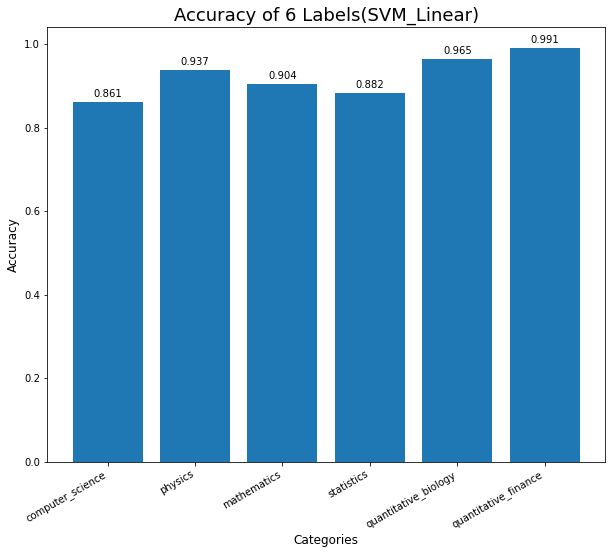

In [59]:
##apply linear kernel svm
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

import time
start = time.time()

svc_linear=ClassifierChain(LinearSVC(random_state=0, C=0.25,penalty='l2'))
svc_linear.fit(xx_train_vectors, xy_train)
predicted=svc_linear.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(test_score)
print(f1)
 
print("Inference - Finished in {}s".format((time.time() - start)))


predicted=predicted.toarray()#transform from sparse to array

score=[]
for i in range(6):
    score.append(accuracy_score(xy_test[:,i],predicted[:,i]))

categories = ['computer_science','physics','mathematics', 'statistics', 'quantitative_biology', 'quantitative_finance']

labels= np.around(np.array(score),3)# round score
print(labels)
fig, ax = plt.subplots(figsize=(10, 8))
rects= ax.bar(categories,labels)
plt.title("Accuracy of 6 Labels(SVM_Linear)", fontsize=18)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Categories', fontsize=12)
ax.set_xticklabels(categories , rotation=30, ha='right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.savefig('accuracy_6labels_3.pdf')
plt.show()



In [8]:
##apply gaussian kernel svm
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import SVC

import time
start = time.time()

svm_gk=ClassifierChain(SVC(C=4,kernel='rbf',gamma='scale',random_state=0))
svm_gk.fit(xx_train_vectors, xy_train)
predicted=svm_gk.predict(xx_test_vectors)
test_score=accuracy_score(xy_test,predicted)
f1=f1_score(xy_test,predicted,average='micro')
print(test_score)
print(f1)
 
print("Inference - Finished in {}s".format((time.time() - start)))

0.6852065876914186
0.8137808137808137
Inference - Finished in 76793.71087217331s


In [ ]:
0.6852065876914186
0.8137808137808137
Inference - Finished in 76793.71087217331s

In [ ]:
##Calculate 3 accuracy

from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import SVC

import time
start = time.time()

svm_gk=ClassifierChain(SVC(C=4,kernel='rbf',gamma='scale',random_state=0))
svm_gk.fit(xx_train_vectors, xy_train)
predicted=svm_gk.predict(xx_test_vectors)

print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

## overall plot

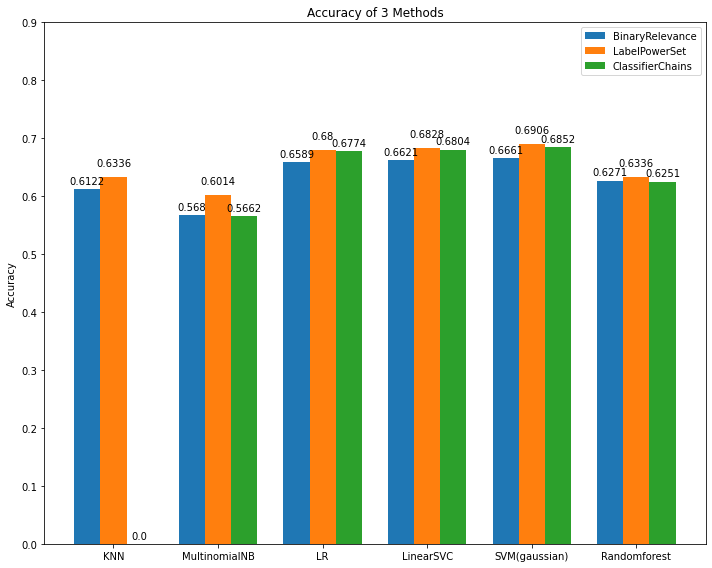

In [75]:

labels=['KNN','MultinomialNB','LR','LinearSVC','SVM(gaussian)','Randomforest']
br_accuracy=[0.6122,0.5680,0.6589,0.6621,0.6661,0.6271]
lps_accuracy=[0.6336,0.6014,0.68,0.6828,0.6906,0.6336]
chain_accuracy=[0,0.5662,0.6774,0.6804,0.6852,0.6251]


import matplotlib
import matplotlib.pyplot as plt
import numpy as np



x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x - width, br_accuracy, width, label='BinaryRelevance')
rects2 = ax.bar(x , lps_accuracy,width, label='LabelPowerSet')
rects3 = ax.bar(x + width, chain_accuracy, width, label='ClassifierChains')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of 3 Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,0.9)
ax.legend()


def autolabel1(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height+0.01),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel1(rects1)
autolabel2(rects2)
autolabel1(rects3)
fig.tight_layout()

plt.savefig('overall accuracy.pdf')
plt.show();


# 4 SMOTE for imbalance

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

In [ ]:
# borderline-SMOTE with SVM for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
from matplotlib import pyplot
from numpy import where
# # define dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
# 	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SVMSMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# 5 Multilearn Adaption

In [67]:

from skmultilearn.adapt import MLkNN
import time
start = time.time()

classifier = MLkNN(k=3)
# train
classifier.fit(xx_train_vectors, xy_train)
# predict
predicted = classifier.predict(xx_test_vectors)
predicted=predicted.toarray()

print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))



Test Accuracy: 0.5784
Fractional Accuracy: 0.8961
Average Accuracy: 0.8961
Inference - Finished in 35.92141604423523s


In [49]:
#MLARAM

import time
start = time.time()

from skmultilearn.adapt import MLARAM
classifier = MLARAM(threshold=0.05, vigilance=0.9)
classifier.fit(xx_train_vectors, xy_train)
predicted = classifier.predict(xx_test_vectors)

print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))


Test Accuracy: 0.0208
Fractional Accuracy: 0.6900
Average Accuracy: 0.6900
Inference - Finished in 160.1446521282196s


In [ ]:
#MLTSVM
from skmultilearn.adapt import MLTSVM

classifier = MLTSVM(c_k = 2**-2)
classifier.fit(xx_train_vectors, xy_train)
predicted = classifier.predict(xx_test_vectors)

print('Test Accuracy: %.4f' % accuracy_score(xy_test,predicted))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predicted))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predicted))

print("Inference - Finished in {}s".format((time.time() - start)))

# 6 NN

In [98]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(300, input_dim=n_inputs, kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit the keras model on the dataset
history=model.fit(x_train, xy_train, epochs=10, batch_size=500, verbose=1)
# make class predictions with the model
predicted= model.predict(x_test)
predict_class=predicted.round()

Epoch 1/10
29/29 [==============================] - 9s 320ms/step - loss: 0.5089 - accuracy: 0.4000
Epoch 2/10
29/29 [==============================] - 8s 268ms/step - loss: 0.3059 - accuracy: 0.7467
Epoch 3/10
29/29 [==============================] - 8s 259ms/step - loss: 0.1982 - accuracy: 0.7996
Epoch 4/10
29/29 [==============================] - 7s 258ms/step - loss: 0.1496 - accuracy: 0.8062
Epoch 5/10
29/29 [==============================] - 7s 257ms/step - loss: 0.1179 - accuracy: 0.8199
Epoch 6/10
29/29 [==============================] - 8s 261ms/step - loss: 0.0923 - accuracy: 0.8291
Epoch 7/10
29/29 [==============================] - 9s 296ms/step - loss: 0.0688 - accuracy: 0.8475
Epoch 8/10
29/29 [==============================] - 9s 317ms/step - loss: 0.0501 - accuracy: 0.8650
Epoch 9/10
29/29 [==============================] - 9s 311ms/step - loss: 0.0356 - accuracy: 0.8756
Epoch 10/10
29/29 [==============================] - 8s 286ms/step - loss: 0.0252 - accuracy: 0.8813

Test Accuracy: 0.6537
Fractional Accuracy: 0.9220
Average Accuracy: 0.9220
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 300)               11508300  
_________________________________________________________________
dropout_16 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_17 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 1806      
Total params: 11,600,406
Trainable params: 11,600,406
Non-trainable params: 0
_________________________________________________________________
None


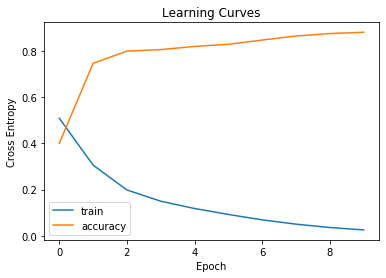

In [100]:
print('Test Accuracy: %.4f' % accuracy_score(xy_test,predict_class))
print('Fractional Accuracy: %.4f' % accuracy_fraction(xy_test, predict_class))
print('Average Accuracy: %.4f' % accuracy_average(xy_test, predict_class))
print(model.summary())

from matplotlib import pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
plt.plot(history.history['accuracy'],label='accuracy')
pyplot.legend()
pyplot.show()

# Methods Comparison

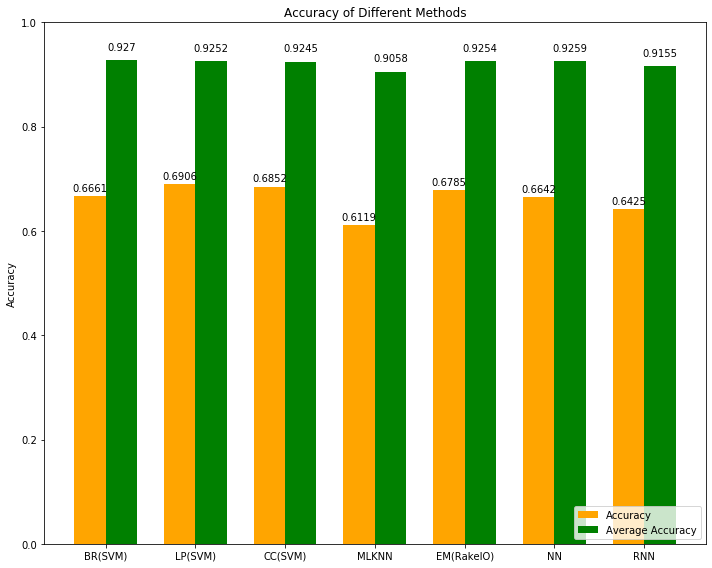

In [47]:
labels=['BR(SVM)','LP(SVM)','CC(SVM)','MLKNN','EM(RakelO)','NN','RNN']
accuracy=[0.6661,0.6906,0.6852,0.6119,0.6785,0.6642,0.6425]
Ave_accuracy=[0.9270,0.9252,0.9245,0.9058,0.9254,0.9259,0.9155]


import matplotlib
import matplotlib.pyplot as plt
import numpy as np



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy',color='orange')
rects2 = ax.bar(x + width/2 , Ave_accuracy,width, label='Average Accuracy',color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)
ax.legend(loc='lower right')


def autolabel1(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height+0.01),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel1(rects1)
autolabel2(rects2)
fig.tight_layout()

plt.savefig('experiment accuracy.pdf')
plt.show();
